In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[0]).unwrapped

discrete_actions = True

if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    
import gc

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2
all_a = 0.01

In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/population_out_size
        ex = math.ceil(ex**(1/(i+1)))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    print("Choice : {}".format(choice))
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,all_a,device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_explore_all = []
    gen_exploit_all = []
    dis_loss_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r = dis(real_batch).squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (nn.MSELoss()(dis_out_r,rank))
            dis_error_real.backward(retain_graph=True)
            dis_optimizer.step() 
            
            #generate children from population
            child,a_gen = gen_children(population,device,gen,batch_size,a = all_a)
            
            #train discriminator
            dis_out_f = dis(child).squeeze(-1)
            gen_optimizer.zero_grad()
            
            #define generator loss
            exploration = torch.std(dis_out_f)
            gen_error_exploration = -exploration-dis_error_real
            gen_error_exploitation = -torch.mean(dis_out_f) #+ torch.mean(a_gen)
            gen_error = gen_error_exploration + gen_error_exploitation
            
            gen_error.backward()
            gen_optimizer.step() 
            
            #keep losses to draw graph   
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            dis_loss_all.append(dis_error_real)  
    print(get_params(population[0]))
    print()
            
    return gen_explore_all,gen_exploit_all, dis_loss_all,all_a


starting training
142
Measured population fitness : 0s
population fitness : [10.  9. 15. 15.  8.  9. 10. 41. 13. 32.]
mean fit : 16.2
tensor([-0.5844, -0.6786, -0.6786, -0.7729, -0.1131,  1.4892, -0.1131, -0.5844,
        -0.3016,  2.3375], device='cuda:0')
tensor([-0.5844, -0.6786, -0.6786, -0.7729, -0.1131,  1.4892, -0.1131, -0.5844,
        -0.3016,  2.3375], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.2333,  0.0222, -0.3802, -0.0994,  0.4392, -0.3098,  0.1872,  0.0641,
        -0.2640,  0.2763,  0.0104, -0.3154,  0.0725, -0.0555,  0.2135, -0.3300,
        -0.0376, -0.3572,  0.1853,  0.4405,  0.4404, -0.4347,  0.3710, -0.3632,
        -0.0066,  0.4162,  0.1522, -0.1811,  0.3230,  0.1261,  0.4378, -0.2939,
        -0.2625,  0.0673, -0.1318,  0.4077,  0.2860,  0.3427,  0.2143,  0.2582,
         0.3964, -0.4244,  0.3937, -0.2964,  0.1471, -0.1023,  0.4428, -0.1805,
        -0.4342, -0.3785,  0.1121, -0.0294, -0.2847,  0.1305,  0.4463, -0.3330,
        -0.0904, -0.4508, -0.1

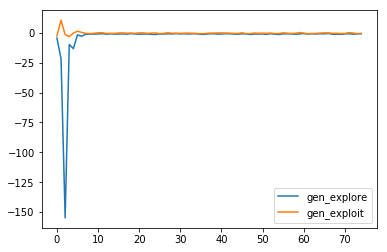

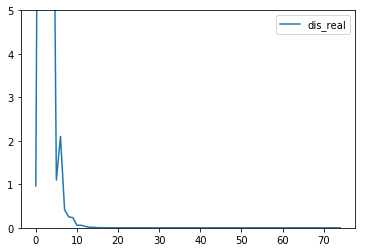

Generation 1  fitness : 41.0
#################################
Measured population fitness : 0s
population fitness : [13. 10. 28.  8. 10.  9. 10. 22. 24. 26.]
mean fit : 16.0
tensor([ 1.2908,  0.6400, -0.8786,  2.7009, -0.3363, -0.1193, -0.6617,  1.0739,
        -0.1193, -0.7701, -0.6617, -0.7701, -0.6617, -0.8786, -0.6617,  1.7247,
        -0.7701, -0.3363, -0.6617,  0.8569], device='cuda:0')
tensor([ 1.2902,  0.6413, -0.8790,  2.7011, -0.3360, -0.1172, -0.6618,  1.0744,
        -0.1196, -0.7705, -0.6605, -0.7702, -0.6634, -0.8790, -0.6617,  1.7235,
        -0.7713, -0.3359, -0.6627,  0.8557],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.2783, -0.1084, -0.1517,  0.2967, -0.2992, -0.4487, -0.1608, -0.1592,
        -0.3704, -0.0046,  0.0000,  0.0000,  0.4067,  0.0783, -0.0502,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0986,  0.0000,  0.0000,  0.3372,  0.0000,
         0.0000, -0.2581,  0.3231, -0.0833, -0.2483,  0.0154,  0.0336,  0.0000,
         0.0000,  0.4675, 

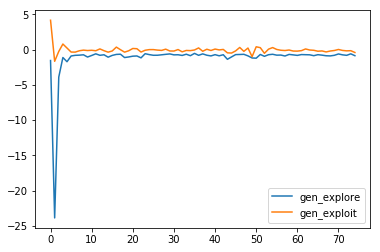

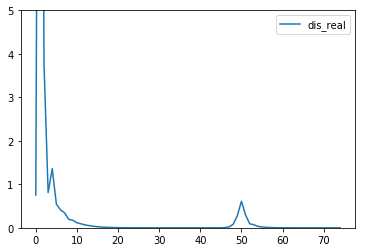

Generation 2  fitness : 28.0
#################################
Measured population fitness : 0s
population fitness : [64. 12. 54. 10.  9. 40. 10. 50. 23. 25.]
mean fit : 29.7
tensor([-0.7833,  0.0091,  0.3139,  1.6550,  0.1311, -0.7833,  0.1920,  1.8988,
        -0.6614,  2.5084,  0.0701,  1.0454, -0.0518, -0.7833, -0.7833, -0.9052,
        -0.6004, -0.8442, -0.8442, -0.7833], device='cuda:0')
tensor([-0.8224,  0.0692,  0.2063,  1.7463,  0.1580, -0.8443,  0.3105,  1.7815,
        -0.4898,  2.6119,  0.1357,  1.1703, -0.1624, -0.8791, -0.8033, -1.0305,
        -0.5368, -0.9355, -0.9866, -0.9388],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.1811,  0.0000, -0.0164,  0.0000, -0.2520,  0.2117, -0.1685,  0.0000,
         0.2146,  0.0000,  0.1077, -0.1643,  0.0905,  0.3396, -0.3521, -0.0202,
        -0.3605,  0.0527, -0.1638,  0.0306,  0.3611,  0.0000, -0.2853, -0.3118,
         0.0000,  0.0000,  0.0881, -0.0352, -0.1854, -0.0150,  0.0636,  0.0547,
         0.0000,  0.1546, 

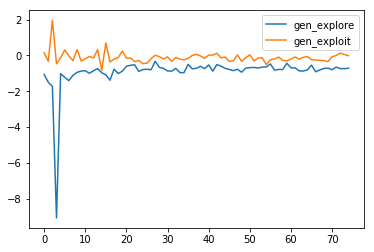

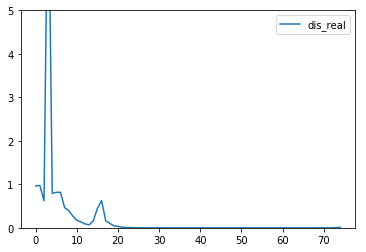

Generation 3  fitness : 64.0
#################################
Measured population fitness : 0s
population fitness : [  9.   9.  17.  40.  15.   9.  42.  61.   9. 108.]
mean fit : 31.9
tensor([ 0.4342, -0.8452, -0.8452,  0.3567,  1.1709,  2.9931,  0.7444, -0.8452,
         0.3567, -0.5350, -0.3024,  0.8995, -0.8452, -0.7289, -0.8452,  1.2872,
        -0.2249, -0.6126, -0.8064, -0.8064], device='cuda:0')
tensor([ 0.5845, -0.8389, -0.7993,  0.4737,  1.2823,  3.2373,  0.8020, -0.8413,
         0.4625, -0.4524, -0.2182,  1.0760, -0.8154, -0.6947, -0.7875,  1.4435,
        -0.2003, -0.5538, -0.7890, -0.7706],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0383, -0.0215,  0.3978, -0.0277,  0.0000,  0.0961,  0.0000,
         0.0000, -0.4101,  0.0000, -0.2024,  0.0000,  0.0000,  0.3306, -0.2229,
         0.0000,  0.0156, -0.0180, -0.1160,  0.0000,  0.2114,  0.0000, -0.4292,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0257,  0.0000, -0.0504,  0.0000,
         0.0000,

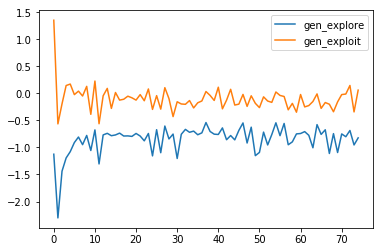

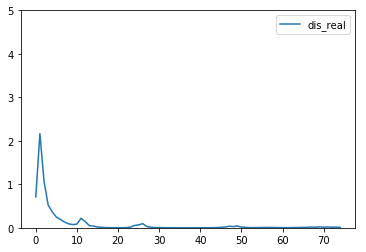

Generation 4  fitness : 108.0
#################################
Measured population fitness : 0s
population fitness : [ 11.  49.   8. 204.  10.  45.  10. 128.  24.  34.]
mean fit : 52.3
tensor([-0.5493, -0.1642,  1.3357,  0.1399, -0.6709, -0.0020, -0.6709,  1.7411,
        -0.3669, -0.6709,  0.3831, -0.6506, -0.6709, -0.6506,  3.2815, -0.6912,
         0.0588, -0.6304, -0.0426, -0.5088], device='cuda:0')
tensor([-0.7908, -0.1594,  1.5924,  0.0160, -0.7374, -0.0399, -0.9901,  1.7474,
        -0.6245, -0.7071,  0.4244, -0.6497, -1.0330, -0.9375,  3.5895, -0.7446,
         0.0583, -0.6496, -0.0932, -0.6369],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0930, -0.1363,  0.0000, -0.2838, -0.1806,  0.0000, -0.1732,
        -0.3550,  0.0000,  0.1230,  0.0000,  0.1058,  0.3212, -0.0348,  0.0000,
         0.0000,  0.0446,  0.0000,  0.0152,  0.3457,  0.0000,  0.0000,  0.0000,
         0.0000, -0.2300,  0.0000, -0.0825, -0.2471,  0.0000,  0.0000,  0.0555,
         0.0000

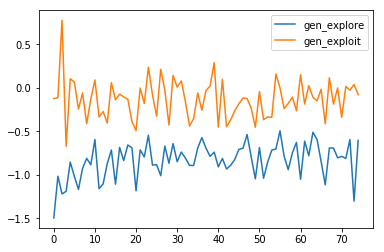

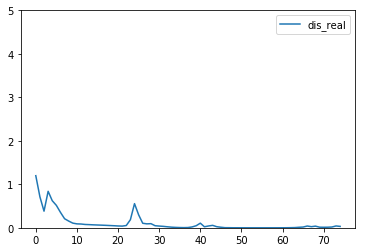

Generation 5  fitness : 204.0
#################################
Measured population fitness : 0s
population fitness : [ 29.   8.  49. 114.  16.  13.  10.  67. 155.  74.]
mean fit : 53.5
tensor([ 1.1212, -0.3468,  2.7728,  0.3872, -0.7872, -0.0716, -0.8239, -0.6771,
        -0.4386, -0.7322,  1.8736, -0.7872, -0.8239, -0.1450,  1.3781,  0.2587,
        -0.5303, -0.7872, -0.0716, -0.7689], device='cuda:0')
tensor([ 1.1593, -0.3831,  2.9006,  0.4858, -0.7558, -0.0925, -0.8003, -0.6003,
        -0.4233, -0.7120,  1.7730, -0.7873, -0.7891, -0.1825,  1.5918,  0.2824,
        -0.4460, -0.7405,  0.0150, -0.7556],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0806, -0.1238,  0.0000, -0.2714, -0.1821,  0.0000, -0.1633,
        -0.3431,  0.0000,  0.1355,  0.0000,  0.1071,  0.3088, -0.0223,  0.0000,
         0.0000,  0.0394,  0.0000,  0.0000,  0.3332,  0.0000,  0.0000,  0.0000,
         0.0000, -0.2180,  0.0000, -0.0711, -0.2355,  0.0000,  0.0000,  0.0430,
         0.0000

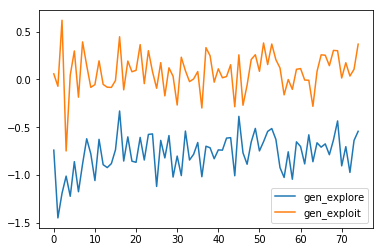

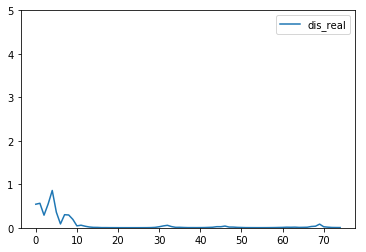

Generation 6  fitness : 155.0
#################################
Measured population fitness : 0s
population fitness : [18. 65. 84. 10. 21.  9.  9. 18. 19. 28.]
mean fit : 28.1
tensor([ 0.6623, -0.8038,  2.8867, -0.6269,  1.0920, -0.8038, -0.5511, -0.7785,
        -0.5005, -0.3236,  0.8392, -0.7785, -0.7027, -0.8291, -0.2983, -0.5763,
        -0.5763,  0.2073,  0.6117,  1.8503], device='cuda:0')
tensor([ 0.6029, -0.7844,  2.7398, -0.6097,  1.0309, -0.7375, -0.5446, -0.8152,
        -0.5206, -0.3330,  0.7897, -0.7694, -0.6918, -0.8282, -0.2869, -0.5269,
        -0.5591,  0.1692,  0.5576,  1.7739],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0806, -0.0984,  0.4103, -0.2714, -0.4585,  0.0836, -0.1573,
        -0.3436,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3183,  0.0000,
         0.0000,  0.0066,  0.0000,  0.0000,  0.0000,  0.2199,  0.0000,  0.0000,
         0.0000, -0.2474,  0.0000, -0.0701, -0.2309,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,

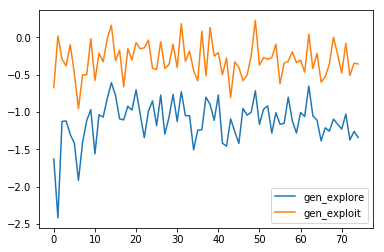

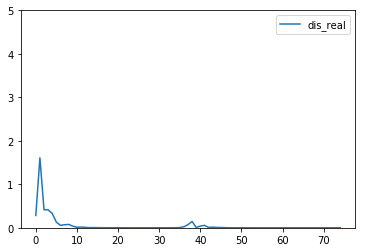

Generation 7  fitness : 84.0
#################################
Measured population fitness : 0s
population fitness : [133.  28. 102.  11.  84.  20.  41.   9. 167.   9.]
mean fit : 60.4
tensor([ 0.8801, -0.7583, -0.3598, -0.5812, -0.5369, -0.7804, -0.7362,  0.4594,
        -0.5148, -0.7804, -0.5590,  2.7177,  1.2786, -0.7804, -0.3598, -0.0720,
         1.9649, -0.5812,  0.8801, -0.7804], device='cuda:0')
tensor([ 0.6946, -0.2263, -0.6808, -0.2456, -0.7580, -0.5524, -0.3039,  0.0900,
        -0.2290, -0.5484, -0.8038,  1.3565,  0.6935, -0.6456,  0.3582, -0.2577,
         1.2983, -0.6897, -0.0181, -0.6038],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0705, -0.1137,  0.0000, -0.2613, -0.1917,  0.0000, -0.1536,
        -0.3525,  0.0000,  0.1456,  0.0000,  0.0970,  0.3082,  0.0000,  0.0000,
         0.0000,  0.0417,  0.0000,  0.0000,  0.3232,  0.0000,  0.0000,  0.0000,
         0.0000, -0.2080,  0.0000, -0.0611, -0.2363,  0.0000,  0.0000,  0.0329,
         0.0000,

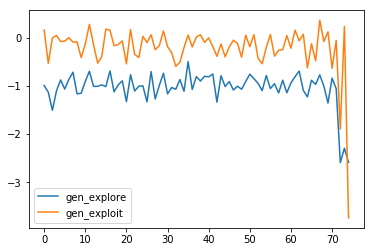

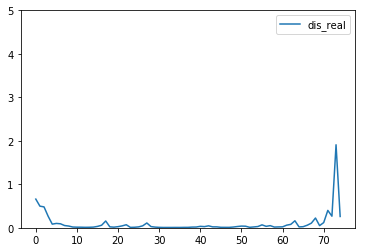

Generation 8  fitness : 167.0
#################################
Measured population fitness : 0s
population fitness : [ 10.  18.  31. 192.  18.  65. 221.  22. 170. 294.]
mean fit : 104.1
tensor([ 0.2375,  1.6683,  0.6102, -0.8687, -0.7244, -0.2074,  1.3196,  0.0210,
        -0.7725, -0.6523,  1.0551, -0.4960, -0.8807, -0.8567,  1.0190, -0.8807,
        -0.7725,  2.5460, -0.6162, -0.7485], device='cuda:0')
tensor([ 0.4085,  1.3960,  0.9179, -0.8948, -0.7205, -0.2006,  1.0098,  0.0521,
        -0.8342, -0.5944,  1.1940, -0.5164, -0.8699, -0.8171,  1.2845, -0.8934,
        -0.8139,  2.3144, -0.7295, -0.7151],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0158,  0.0011,  0.4204, -0.0052,  0.0000,  0.0865,  0.0000,
         0.0000, -0.3842,  0.0000, -0.2039,  0.0000,  0.0000,  0.3128, -0.2234,
        -0.0002,  0.0000,  0.0031,  0.0156,  0.0000,  0.0000,  0.0000, -0.4386,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0155,  0.0000, -0.0475,  0.0030,
         0.000

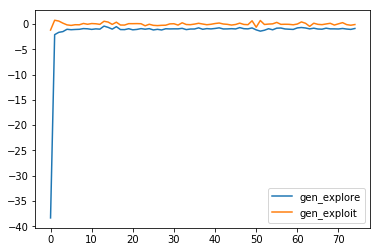

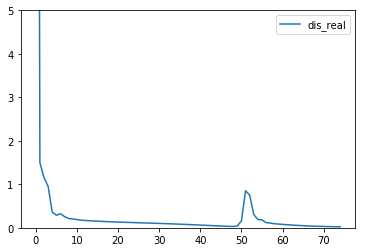

Generation 9  fitness : 294.0
#################################
Measured population fitness : 0s
population fitness : [ 13. 293. 202.  54.  23. 204.  16. 291.  66.  44.]
mean fit : 120.6
tensor([ 1.7298,  0.5520, -0.9801, -0.4438, -0.9035, -0.9513,  1.7394, -0.8652,
         0.8776,  1.7107,  1.0404, -0.9035,  0.8585, -0.5587,  0.7627, -0.9226,
        -0.6545, -0.4534, -0.7790, -0.8556], device='cuda:0')
tensor([ 1.7481,  0.6772, -0.9680, -0.4730, -0.9126, -0.9173,  1.7027, -0.8660,
         0.8418,  1.5055,  0.8398, -0.8871,  0.8290, -0.5761,  0.7253, -0.9165,
        -0.6578, -0.4486, -0.7854, -0.8311],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0076,  0.0000,  0.4286,  0.0030,  0.0000,  0.0918,  0.0000,
         0.0000, -0.3795,  0.0000, -0.2024,  0.0000,  0.0000,  0.2908, -0.2147,
         0.0000,  0.0000,  0.0000,  0.0238,  0.0000,  0.0114,  0.0000, -0.4391,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0056,  0.0000, -0.0395,  0.0000,
         0.000

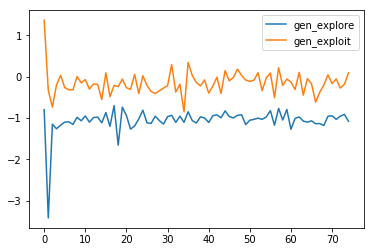

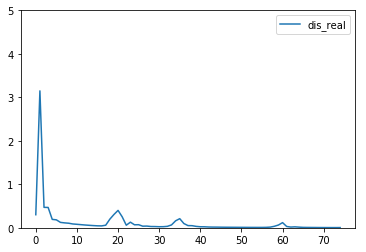

Generation 10  fitness : 293.0
#################################
Measured population fitness : 0s
population fitness : [193. 327. 203. 214. 291.  72.  66.  17.  95. 183.]
mean fit : 166.1
tensor([-0.7369,  0.5588, -0.7369, -1.2133,  0.4730,  1.4258,  1.4067, -1.2419,
         1.4067, -1.2038, -0.8513,  0.5778, -1.1466, -0.6798,  1.7497,  0.3778,
        -0.9465,  0.6731, -0.4606,  0.5683], device='cuda:0')
tensor([-0.6790,  0.5833, -0.7303, -1.2102,  0.5083,  1.4510,  1.5773, -1.2324,
         1.2926, -1.1696, -0.8280,  0.5970, -1.1322, -0.7553,  1.6329,  0.4535,
        -0.8200,  0.7620, -0.4767,  0.5236],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0076,  0.0006,  0.4286,  0.0030,  0.0000,  0.0947,  0.0000,
         0.0000, -0.3760,  0.0000, -0.1210,  0.0000,  0.0000,  0.3132, -0.2241,
         0.0000,  0.0000,  0.0026,  0.0237,  0.0000,  0.0000,  0.0000, -0.4391,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0105,  0.0000, -0.0390,  0.0029,
         0.00

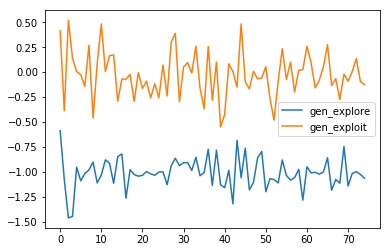

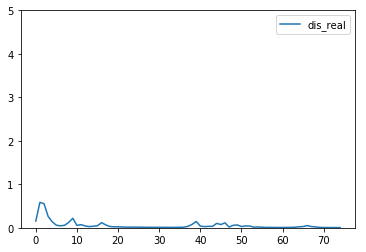

Generation 11  fitness : 327.0
#################################
Measured population fitness : 0s
population fitness : [289. 130. 265. 165. 210. 155.  29. 385.  20.  15.]
mean fit : 166.3
tensor([ 2.0339, -0.1041,  1.1415, -1.2754,  0.9184, -0.0112,  1.1601, -1.4055,
        -0.3365, -0.9314, -1.3591,  0.3421,  0.2491,  1.4948, -0.6619,  0.1562,
        -0.8757, -1.3869,  0.4072,  0.4443], device='cuda:0')
tensor([ 1.5198, -0.0460,  1.2557, -1.0042,  1.1898,  0.2209,  1.2868, -1.3504,
         0.1724, -0.8238, -1.2593,  0.0846,  0.0760,  1.2831, -0.6565,  0.2076,
        -1.0382, -1.3308,  0.1610,  0.1995],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0010,  0.0000,  0.4352,  0.0027,  0.0000,  0.0852,  0.0000,
         0.0000, -0.3694,  0.0000, -0.1277,  0.0000,  0.0000,  0.2842, -0.2174,
         0.0000,  0.0000,  0.0093,  0.0000,  0.0000,  0.0180,  0.0000, -0.4325,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0102,  0.0000, -0.0385,  0.0000,
         0.00

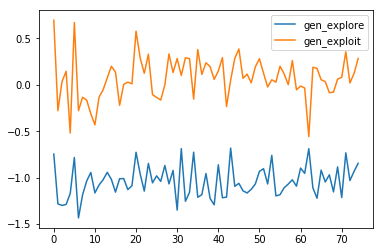

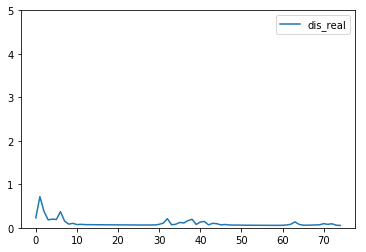

Generation 12  fitness : 385.0
#################################
Measured population fitness : 0s
population fitness : [137.  30. 143.  18. 140. 240. 136. 304. 224. 302.]
mean fit : 167.4
tensor([ 0.5343,  2.0394, -1.2794,  0.4034,  0.6839, -0.0173, -0.2884,  1.1419,
        -1.3728, -1.3915, -1.2887, -0.2791, -0.2510, -0.3445,  0.9176,  1.2635,
        -0.2230, -1.4196,  1.2822, -0.1108], device='cuda:0')
tensor([ 0.5016,  0.4307, -0.7305, -0.0696,  0.4580, -0.0506, -0.0798,  0.4884,
        -0.8461, -0.8972, -0.8342, -0.0366,  0.0007, -0.0718,  0.4457,  0.5031,
        -0.0575, -0.8774,  0.4635, -0.0623],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000,  0.0018,  0.0000,  0.4380,  0.0000,  0.0000,  0.0873,  0.0000,
         0.0000, -0.3740,  0.0000, -0.2330,  0.0000,  0.0000,  0.2814, -0.2190,
         0.0000,  0.0000,  0.0000, -0.0043,  0.0000,  0.0152,  0.0000, -0.4352,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0124,  0.0000, -0.0364,  0.0000,
         0.00

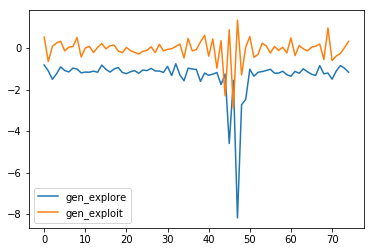

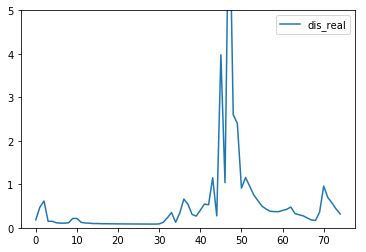

Generation 13  fitness : 304.0
#################################
Measured population fitness : 0s
population fitness : [201. 142. 203. 221. 198. 261. 124. 205.  32. 177.]
mean fit : 176.4
tensor([ 0.6170, -0.4386,  0.6547,  0.3280,  0.8558, -0.4512,  0.3657,  0.4160,
        -1.9341, -1.7581, -0.3632,  1.6350, -0.4009,  0.3908, -1.7833,  1.1197,
         1.6601, -0.3758, -0.6020,  0.0641], device='cuda:0')
tensor([ 0.8234, -0.3256,  0.8183,  0.7640,  0.7600, -0.5908,  0.6125,  0.8161,
        -1.9671, -1.8337, -0.6291,  0.8119, -0.4396,  0.6046, -1.8580,  0.8274,
         0.9290, -0.3149, -0.4182, -0.3148],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0007,  0.0000,  0.4406,  0.0024,  0.0000,  0.0897,  0.0000,
         0.0000, -0.3715,  0.0000, -0.2305,  0.0000,  0.0000,  0.2788, -0.2165,
         0.0000,  0.0000,  0.0146,  0.0000,  0.0000,  0.0126,  0.0000, -0.4378,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0150,  0.0000, -0.0338,  0.0000,
         0.00

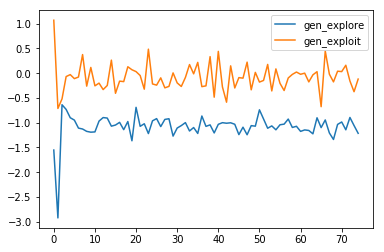

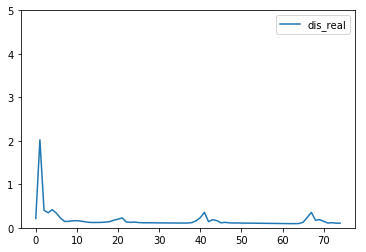

Generation 14  fitness : 261.0
#################################
Measured population fitness : 0s
population fitness : [144. 219. 329. 211. 235. 308. 269. 206. 247. 186.]
mean fit : 235.4
tensor([ 0.8618, -0.0766,  0.6429,  0.2049,  0.0016,  1.5970,  0.0798, -0.0454,
         1.9255, -0.9995, -0.9682, -0.4520, -0.3113, -1.2810,  0.9870,  0.4552,
        -2.7200, -0.1236, -0.0141,  0.2362], device='cuda:0')
tensor([ 1.0436,  1.3623,  0.9611,  1.0054,  1.1132,  1.6915,  1.1222,  1.2010,
         1.4558, -0.0824, -0.5902, -0.0823, -0.2853, -0.6563,  1.1133, -0.2369,
        -3.6211,  1.1756,  1.0349,  1.0376],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0007,  0.0000,  0.4406,  0.0024,  0.0000,  0.0897,  0.0000,
         0.0000, -0.3715,  0.0000, -0.2305,  0.0000,  0.0000,  0.2788, -0.2165,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0126,  0.0000, -0.4378,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0150,  0.0000, -0.0338,  0.0000,
         0.00

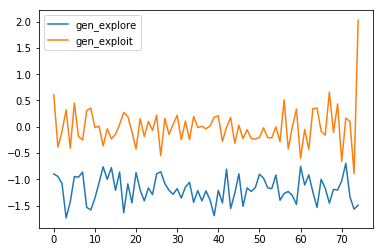

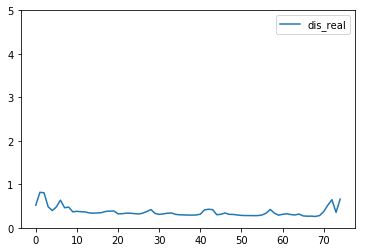

Generation 15  fitness : 329.0
#################################
Measured population fitness : 0s
population fitness : [251. 199. 321. 318. 284. 236. 216. 166. 252. 238.]
mean fit : 248.1
tensor([-0.1144, -0.4524,  0.1044,  0.5419, -1.5065, -1.9440,  0.2038,  1.5164,
         1.3175, -0.0746, -0.8502, -0.5121, -0.7110,  1.5761, -0.6115, -0.1342,
         0.8402, -1.1087,  1.7352,  0.1840], device='cuda:0')
tensor([-0.0800, -0.1783, -0.2031, -0.1444, -0.7298, -2.0047,  0.5930,  0.8072,
         0.8107,  0.8406, -0.7297, -0.0799, -0.1445,  1.3872, -0.1294, -0.7992,
        -0.0992, -1.3616,  1.3075, -0.0799],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0005, -0.0001,  0.4449,  0.0067,  0.0000,  0.0900,  0.0000,
         0.0000, -0.3671,  0.0000, -0.2261,  0.0000,  0.0000,  0.2745, -0.2208,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0083,  0.0000, -0.4421,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0193,  0.0000, -0.0295,  0.0000,
         0.00

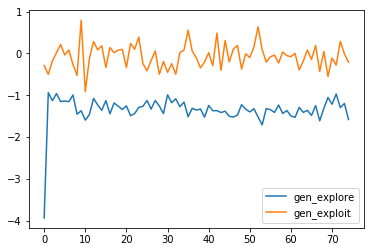

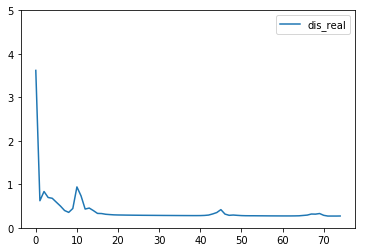

Generation 16  fitness : 321.0
#################################
Measured population fitness : 0s
population fitness : [277. 253. 272. 269. 317. 234. 251. 375. 335. 212.]
mean fit : 279.5
tensor([-0.2591, -0.2591,  0.1660, -0.5223, -0.5628,  2.2513,  1.0973, -0.6033,
         0.4090, -0.2389, -1.9800,  0.1053,  0.2672, -0.2187, -1.3119, -0.9678,
        -1.0487,  1.1581,  1.0771,  1.4415], device='cuda:0')
tensor([ 0.7724,  0.0907,  0.1367,  0.7032,  0.0907,  0.7865,  0.7240,  0.1071,
         0.0637,  0.4434, -1.4734,  0.1351,  0.5501,  0.5046, -1.4733,  0.0907,
        -1.1521,  0.4902,  0.5027,  0.1291],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000,  0.0014,  0.0017,  0.4468,  0.0050,  0.0000,  0.0881,  0.0000,
         0.0000, -0.3578,  0.0000, -0.1973,  0.0000,  0.0000,  0.2726, -0.2082,
         0.0000,  0.0000,  0.0000,  0.0286,  0.0000,  0.0064,  0.0000, -0.4440,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0131,  0.0000, -0.0230,  0.0000,
         0.00

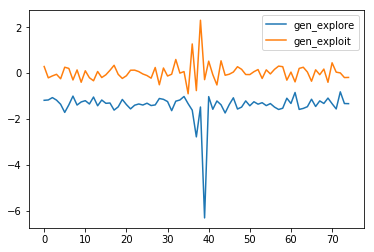

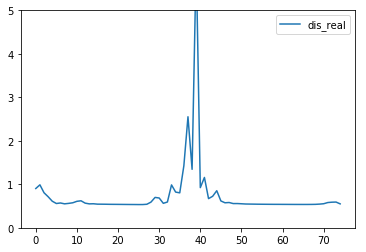

Generation 17  fitness : 375.0
#################################
Measured population fitness : 0s
population fitness : [230. 235. 311. 235. 285. 240. 284. 323. 286. 256.]
mean fit : 268.5
tensor([-0.0494,  0.2469, -0.4444, -1.5306,  0.0741,  2.4934, -0.9628, -0.8394,
         0.2716, -0.1234, -0.5678,  1.5059, -0.5184,  0.2962,  1.0616, -1.0862,
        -0.9875, -0.9628,  0.9134,  1.2097], device='cuda:0')
tensor([ 0.0250,  0.2266, -0.0000, -1.5428, -0.0353,  0.2237,  0.2268,  0.0234,
        -0.0280,  0.0251,  0.2503,  0.0529, -0.0462,  0.0221,  0.0172,  0.0309,
         0.0152,  0.0311,  0.0221,  0.0604],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000,  0.0014,  0.0000,  0.4468,  0.0049,  0.0000,  0.0881,  0.0000,
         0.0000, -0.3653,  0.0000, -0.2243,  0.0000,  0.0000,  0.2726, -0.2190,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0064,  0.0000, -0.4440,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000, -0.0276,  0.0000,
         0.00

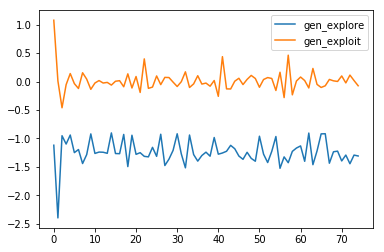

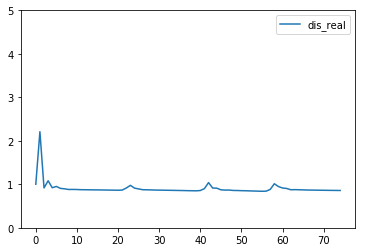

Generation 18  fitness : 323.0
#################################
Measured population fitness : 0s
population fitness : [372. 351. 325. 276. 207. 281. 221. 327. 271. 224.]
mean fit : 285.5
tensor([-0.8150, -0.9252, -1.0353, -0.9252,  2.0927,  1.0133,  1.1014, -1.5420,
         0.1762, -1.1675,  1.0574, -0.0220, -0.1322, -0.4626,  0.0881,  1.6301,
         0.1983,  0.1542, -1.2336,  0.7490], device='cuda:0')
tensor([ 0.0184,  0.1758, -0.3768, -0.3757,  0.6540, -0.3192, -0.3025, -0.3636,
         0.6329, -0.3644,  0.6514, -0.3531, -0.3621,  0.6484,  0.2006,  0.1936,
        -0.3672,  0.1747, -0.3025, -0.3673],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0003,  0.0034,  0.4484,  0.0066,  0.0000,  0.0865,  0.0000,
         0.0000, -0.3596,  0.0000, -0.1958,  0.0000,  0.0000,  0.2710, -0.2036,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0047,  0.0000, -0.4457,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0115,  0.0000, -0.0259,  0.0000,
         0.00

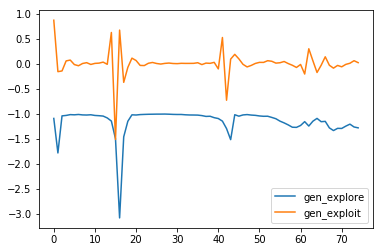

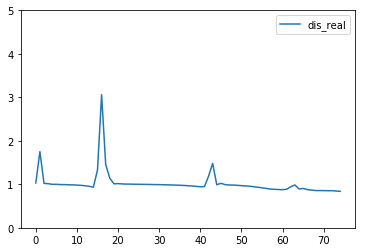

Generation 19  fitness : 372.0
#################################
Measured population fitness : 0s
population fitness : [331. 363. 230. 341. 396. 271. 522. 308. 319. 301.]
mean fit : 338.2
tensor([-1.2421, -0.4362, -1.2845, -0.1534,  0.1011, -0.0544,  0.8504,  0.2142,
         1.1897, -0.5069,  0.2708,  0.7232,  0.1859,  0.4121, -1.4824,  0.5535,
         2.9712, -1.1572, -0.5776, -0.5776], device='cuda:0')
tensor([-0.5372,  0.4643, -0.6153,  1.0000, -0.5015, -0.5671,  1.1129, -0.6158,
         0.5756, -0.6046,  0.5736,  0.4874,  0.9552, -0.4991, -0.5377,  0.5351,
         1.1635, -0.5836, -0.5015, -0.5410],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000,  0.0012,  0.0049,  0.4498,  0.0051,  0.0000,  0.0880,  0.0000,
         0.0000, -0.3651,  0.0000, -0.2211,  0.0000,  0.0000,  0.2725, -0.2158,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0062,  0.0000, -0.4471,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0143,  0.0000, -0.0245,  0.0000,
         0.00

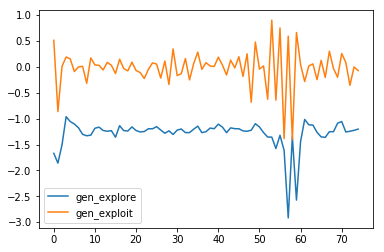

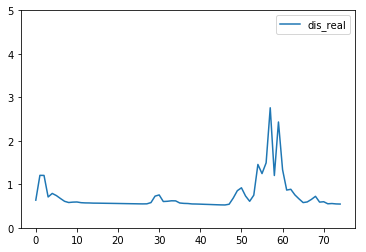

Generation 20  fitness : 522.0
#################################
Measured population fitness : 0s
population fitness : [364. 272. 305. 270. 294. 319. 373. 384. 273. 227.]
mean fit : 308.1
tensor([-0.7683, -0.0636, -0.8143, -0.4466, -0.2781, -0.7837,  0.1203, -1.4731,
        -0.2321, -0.0636, -0.7990,  1.1161,  3.0466, -0.3394,  0.6105,  0.6259,
         0.7637, -1.4271,  0.9323,  0.2735], device='cuda:0')
tensor([ 0.0057,  0.0056, -0.0201,  0.0057, -0.0201, -0.0199,  0.0435,  0.0416,
        -0.0175, -0.0174, -0.0174,  0.0434,  0.0078,  0.0077,  0.0422,  0.0416,
         0.0416, -0.0187,  0.0416, -0.0174],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000,  0.0011,  0.0000,  0.4523,  0.0025,  0.0000,  0.0880,  0.0000,
         0.0000, -0.3551,  0.0000, -0.1104,  0.0000,  0.0000,  0.2750, -0.2088,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0088,  0.0000, -0.4498,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0123,  0.0000, -0.0212,  0.0000,
         0.00

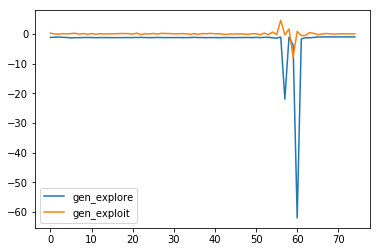

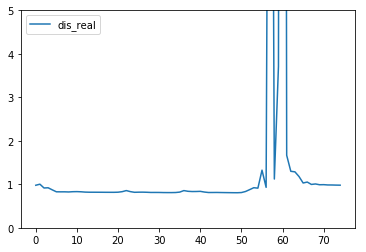

Generation 21  fitness : 384.0
#################################
Measured population fitness : 0s
population fitness : [274. 339. 208. 287. 284. 206. 233. 340. 283. 376.]
mean fit : 283.0
tensor([ 1.2898, -0.4438, -0.1611, -0.2176,  1.4594, -1.2917, -0.4815,  0.8188,
         1.6667, -1.1787,  0.1781, -0.0292, -1.6498,  0.8376,  0.4419, -0.4249,
        -0.2365, -1.6874,  1.5160, -0.4061], device='cuda:0')
tensor([ 0.5166, -0.7171,  0.5125, -0.7343,  0.5162,  0.5171, -0.7155,  0.5108,
         0.5171, -0.0808, -0.7155, -0.0698, -0.7370, -0.0808, -0.0707, -0.0703,
         0.5109, -0.7359,  0.5098,  0.5098],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000,  0.0011,  0.0000,  0.4523,  0.0025,  0.0000,  0.0880,  0.0000,
         0.0000, -0.3551,  0.0000, -0.1915,  0.0000,  0.0000,  0.2750, -0.2024,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0088,  0.0000, -0.4498,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0074,  0.0000, -0.0173,  0.0000,
         0.00

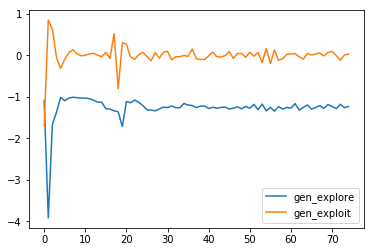

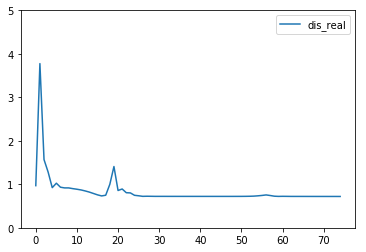

Generation 22  fitness : 376.0
#################################
Measured population fitness : 0s
population fitness : [199. 289. 352. 221. 221. 283. 210. 290. 300. 265.]
mean fit : 263.0
tensor([ 0.3311,  0.5259, -0.1558,  0.2727,  2.0062, -1.2660,  1.5387,  0.2143,
        -1.3050, -1.0128,  0.3116,  1.2855,  0.0195, -1.2271, -1.4413,  0.1948,
         1.3050, -1.0128,  0.1948, -0.7791], device='cuda:0')
tensor([ 0.5183,  0.1310,  0.5229,  0.5250,  0.5185, -0.8840,  0.5228, -0.8775,
        -0.8778,  0.5184,  0.1243,  0.5247,  0.5185, -0.8932, -0.8908,  0.5247,
         0.1278,  0.1243,  0.5159,  0.1278],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0006,  0.0000,  0.4544,  0.0005,  0.0000,  0.0860,  0.0000,
         0.0000, -0.3530,  0.0000, -0.1895,  0.0000,  0.0000,  0.2771, -0.2003,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0067,  0.0000, -0.4518,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0053,  0.0000, -0.0152,  0.0000,
         0.00

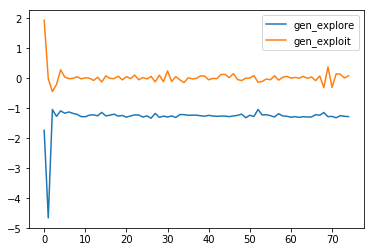

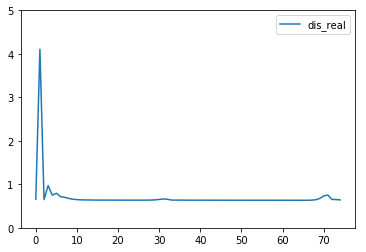

Generation 23  fitness : 352.0
#################################
Measured population fitness : 0s
population fitness : [286. 334. 395. 312. 346. 292. 276. 280. 294. 243.]
mean fit : 305.8
tensor([-1.7558,  0.1974,  0.0946,  1.3898, -0.8512, -0.1727,  0.3207, -0.0288,
        -0.3988, -1.3035,  0.5674, -1.5296, -0.0905,  0.1151,  0.0329,  1.0197,
        -1.3035,  1.2664,  0.1563,  2.2739], device='cuda:0')
tensor([-1.5521, -0.4622, -0.8634, -0.4570, -1.5530, -0.8615, -0.8582, -0.4621,
        -0.4547, -0.4608, -0.4621, -1.5534, -0.4608, -0.4608, -0.8628, -0.4571,
        -0.8634, -0.8577, -0.4622, -0.4547],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000, -0.0006,  0.0000,  0.4544,  0.0005,  0.0000,  0.0860,  0.0000,
         0.0000, -0.3605,  0.0000, -0.2164,  0.0000,  0.0000,  0.2771, -0.2112,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0067,  0.0000, -0.4518,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0096,  0.0000, -0.0198,  0.0000,
         0.00

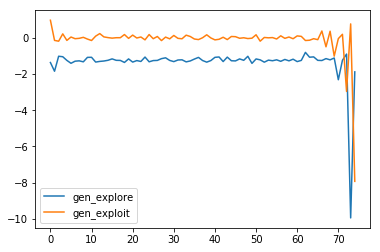

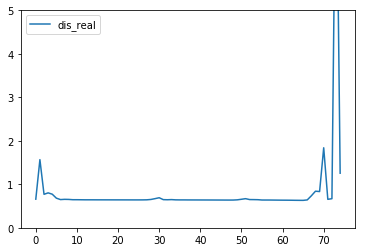

Generation 24  fitness : 395.0
#################################
Measured population fitness : 0s
population fitness : [341. 367. 310. 271. 220. 385. 329. 327. 231. 329.]
mean fit : 311.0
tensor([-0.4805, -0.8023,  1.8578,  0.4419,  0.3990,  1.2571,  1.6433, -0.6092,
        -1.6604,  0.5492,  0.0772, -0.3518, -1.4030, -1.8964, -0.6951, -0.3089,
         0.4419,  0.0343,  0.6993,  0.8066], device='cuda:0')
tensor([ 0.0096,  0.1038,  0.1061,  0.1036,  0.1035,  0.1021,  0.0080,  0.1044,
         0.1010,  0.1062,  0.1034,  0.1034, -1.4012,  0.0082,  0.0106,  0.1034,
         0.1013,  0.1038,  0.0104,  0.0123],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0000,  0.0002,  0.0104,  0.4553, -0.0004,  0.0000,  0.0851,  0.0000,
         0.0000, -0.3521,  0.0000, -0.1074,  0.0000,  0.0000,  0.2780, -0.2059,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0058,  0.0000, -0.4527,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0094,  0.0000, -0.0183,  0.0000,
         0.00

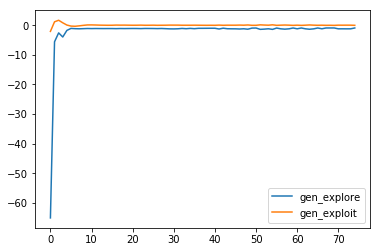

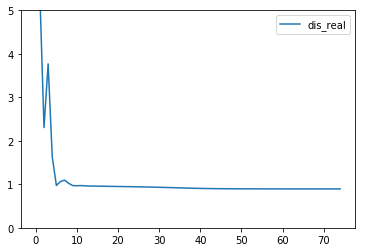

Generation 25  fitness : 385.0
#################################


KeyboardInterrupt: 

In [4]:
population_size = 10
max_population = population_size
max_population_batch = 2
out_size = population_size
n_generations = 300

#randomly inititialise starting population
population = []
for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)


print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

for i in range(n_generations):
    all_a *= 0.9
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001,betas=(0.5,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.01,betas=(0.5,0.999))
   
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    fitness_batch = ((fitness_batch - np.mean(fitness_batch))/np.sqrt(np.var(fitness_batch)+epsilon))
    #fitness_batch = np.minimum(0,fitness_batch)
    #Train GAN
    start_time = time.time()
    gen_explore_all,gen_exploit_all, dis_loss ,all_a= train_gan(population_batch,fitness_batch,
              batch_size =len(population_batch),n_epochs = 75)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    mutation_scale = 0#.1
    mutation_rate = 0#.3
    mutation_rate = np.random.choice([0.1, 0], p_fitness_.shape,p=[mutation_rate,1-mutation_rate])
    
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mutation_rate,mutation_scale)
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
#env = gym.make(envs[-2]).unwrapped

p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)


In [ ]:
fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 50000)
print(fitness)

In [ ]:
yeet = torch.rand([1,10])
print(torch.clamp(yeet,0,0.5))

In [ ]:
print(len(list(torch.zeros([5,3]).shape)))